In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip check

ipython 7.34.0 requires jedi, which is not installed.
torch 2.6.0+cu124 has requirement nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2.
torch 2.6.0+cu124 has requirement nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82.
torch 2.6.0+cu124 has requirement nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82.
torch 2.6.0+cu124 has requirement nvidia-cuda-runtime-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-runtime-cu12 12.5.82.
torch 2.6.0+cu124 has requirement nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75.
torch 2.6.0+cu124 has requirement nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux

#### Prepare Asian Images

In [ ]:
!pip install -q dlib opencv-python

!wget -O predictor.bz2 http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk predictor.bz2

import os
os.rename("predictor", "shape_predictor_68_face_landmarks.dat")

# data.zip
from google.colab import files
uploaded = files.upload()

--2025-06-10 07:27:26--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-06-10 07:27:27--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘predictor.bz2’

predictor.bz2       100%[===================>]  61.07M  36.3MB/s    in 1.7s    

2025-06-10 07:27:29 (36.3 MB/s) - ‘predictor.bz2’ saved [64040097/64040097]



Saving data.zip to data.zip


In [ ]:
import zipfile, os

zip_path = next(iter(uploaded))
extract_dir = "data"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

import cv2
import dlib
import numpy as np

predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
detector = dlib.get_frontal_face_detector()

output_dir = "output_384x286"
os.makedirs(output_dir, exist_ok=True)

from glob import glob
from tqdm import tqdm

img_paths = sorted(glob(f"{extract_dir}/**/*.jpg", recursive=True))

for path in tqdm(img_paths):
    name = os.path.splitext(os.path.basename(path))[0]
    img = cv2.imread(path)
    if img is None:
        continue

    resized = cv2.resize(img, (384, 286))
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

    dets = detector(gray, 1)
    if len(dets) == 0:
        continue

    shape = predictor(gray, dets[0])
    landmarks = np.array([[p.x, p.y] for p in shape.parts()])

    left_eye = landmarks[36:42]
    right_eye = landmarks[42:48]

    left_center = np.mean(left_eye, axis=0)
    right_center = np.mean(right_eye, axis=0)

    cv2.imwrite(f"{output_dir}/{name}.jpg", gray)
    with open(f"{output_dir}/{name}.eye", "w") as f:
        f.write(f"{left_center[0]:.2f} {left_center[1]:.2f} {right_center[0]:.2f} {right_center[1]:.2f}\n")

!zip -r output_384x286.zip output_384x286
files.download("output_384x286.zip")

KeyboardInterrupt: 

In [ ]:
import os, shutil, cv2
from glob import glob

scut_dir = "output_384x286"
bioid_dir = "/content/drive/MyDrive/BioID-FaceDatabase-V1.2"
merged_dir = "BioID-multi-race"

os.makedirs(merged_dir, exist_ok=True)

bioid_pgms = glob(f"{bioid_dir}/**/*.pgm", recursive=True)
bioid_eyes = glob(f"{bioid_dir}/**/*.eye", recursive=True)

for f in bioid_pgms + bioid_eyes:
    shutil.copy(f, os.path.join(merged_dir, os.path.basename(f)))

scut_jpgs = glob(f"{scut_dir}/*.jpg")

for jpg_path in scut_jpgs:
    base = os.path.splitext(os.path.basename(jpg_path))[0]

    img = cv2.imread(jpg_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue

    pgm_out = os.path.join(merged_dir, base + ".pgm")
    cv2.imwrite(pgm_out, img)

    eye_src = os.path.join(scut_dir, base + ".eye")
    eye_dst = os.path.join(merged_dir, base + ".eye")
    if os.path.exists(eye_src):
        shutil.copy(eye_src, eye_dst)

print(f"Merged: {len(os.listdir(merged_dir))} files in '{merged_dir}/'")

#### 이미 추가 되었다면(BioID-multi-race), 여기서부터

In [ ]:
import shutil
import os

drive_target_dir = "/content/drive/MyDrive/BioID-multi-race"

if os.path.exists(drive_target_dir):
    shutil.rmtree(drive_target_dir)

shutil.copytree("BioID-multi-race", drive_target_dir)

print("EndSave")

In [ ]:
!pip install -q opencv-python dlib

import os, cv2, struct, zipfile
import numpy as np
import dlib
from glob import glob
from tqdm import tqdm
from google.colab import files


# data.zip
uploaded = files.upload()

KeyboardInterrupt: 

In [ ]:
zip_filename = next(iter(uploaded))

extract_dir = "data"
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
detector = dlib.get_frontal_face_detector()

def read_scaled_pts(path, img_shape, target_shape=(384, 286)):
    with open(path, 'rb') as f:
        raw = f.read()
    pts = struct.unpack('f' * 172, raw)
    pts = np.array(pts).reshape((86, 2))
    h0, w0 = img_shape
    w1, h1 = target_shape
    scale_x, scale_y = w1 / w0, h1 / h0
    return pts * [scale_x, scale_y]

out_dir = "output"
os.makedirs(out_dir, exist_ok=True)

img_paths = sorted(glob(f"{extract_dir}/*.jpg"))
for img_path in tqdm(img_paths):
    name = os.path.splitext(os.path.basename(img_path))[0]
    pts_path = os.path.join(extract_dir, name + ".pts")
    if not os.path.exists(pts_path):
        continue

    img = cv2.imread(img_path)
    if img is None:
        continue
    orig_h, orig_w = img.shape[:2]
    resized = cv2.resize(img, (384, 286))
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

    pts = read_scaled_pts(pts_path, (orig_h, orig_w))
    left_eye = pts[36:42]
    right_eye = pts[42:48]
    left_center = np.mean(left_eye, axis=0)
    right_center = np.mean(right_eye, axis=0)

    y_diff = left_center[1] - right_center[1]
    if abs(y_diff) > 15:
        dets = detector(gray, 1)
        if len(dets) > 0:
            shape = predictor(gray, dets[0])
            landmarks = np.array([[p.x, p.y] for p in shape.parts()])
            left_center = np.mean(landmarks[36:42], axis=0)
            right_center = np.mean(landmarks[42:48], axis=0)

    with open(os.path.join(out_dir, name + ".eye"), "w") as f:
        f.write(f"{left_center[0]:.2f} {left_center[1]:.2f} {right_center[0]:.2f} {right_center[1]:.2f}\n")

    pgm_path = os.path.join(out_dir, name + ".pgm")
    cv2.imwrite(pgm_path, gray)

0it [00:00, ?it/s]


#### 모델 학습

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# # base_path = "/content/drive/MyDrive/SafeAI/BioID-FaceDatabase-V1.2"
# base_path = "/content/drive/MyDrive/BioID-multi-race"
# image_files = sorted([f for f in os.listdir(base_path) if f.endswith(".pgm")])
# label_files = sorted([f for f in os.listdir(base_path) if f.endswith(".eye")])

# print(len(image_files))
# print(len(label_files))

2945
2945


In [ ]:
# base_path = "/content/drive/MyDrive/SafeAI_Final/BioID-multi-race"
base_path = "/content/drive/MyDrive/BioID-multi-race"
image_files = sorted([f for f in os.listdir(base_path) if f.endswith(".pgm")])
label_files = sorted([f for f in os.listdir(base_path) if f.endswith(".eye")])

print(len(image_files))
print(len(label_files))

data = []
for img_file, label_file in zip(image_files, label_files):
    img_path = os.path.join(base_path, img_file)
    label_path = os.path.join(base_path, label_file)

    with open(label_path, "r") as f:
        lines = f.readlines()
        if len(lines) == 1:
            lx, ly, rx, ry = map(float, lines[0].strip().split())
        else:
          lx, ly, rx, ry = map(float, lines[1].strip().split())
        # print(f"left: {lx}, {ly} / right: {rx}, {ry}")
        data.append((img_path, [lx, ly, rx, ry]))


2945
2945


In [ ]:
len(data)

2945

In [ ]:
random.seed(42)
random.shuffle(data)

holdout_data = data[:21]    # 비교용
remaining_data = data[21:]  # 학습용

df = pd.DataFrame(remaining_data, columns=["image_path", "eye_coords"])
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

holdout_df = pd.DataFrame(holdout_data, columns=["image_path", "eye_coords"])

print(len(remaining_data))

2924


In [ ]:
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = image.astype(np.float32) / 255.0
    image = np.expand_dims(image, axis=0)  # (1, H, W)
    return image  # (1, 286, 384)

In [ ]:
class EyeDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = preprocess_image(row["image_path"])  # (1, 128, 128)
        label = np.array(row["eye_coords"], dtype=np.float32)
        return torch.tensor(image), torch.tensor(label)

In [ ]:
class HoldoutDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = preprocess_image(row["image_path"])  # (1, H, W)
        label = np.array(row["eye_coords"], dtype=np.float32)
        return torch.tensor(image), torch.tensor(label)

In [ ]:
class EyeCNN(nn.Module):
    def __init__(self):
        super(EyeCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (286, 384) → (143, 192)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (143, 192) → (71, 96)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (71, 96) → (35, 48)

            nn.AdaptiveAvgPool2d((4, 6)), # 128 * 4 * 6 = 3072
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(3072, 256),
            nn.ReLU(),
            nn.Linear(256, 4)  # [lx, ly, rx, ry]
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
train_dataset = EyeDataset(train_df)
test_dataset = EyeDataset(test_df)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

model = EyeCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Training

In [ ]:
epochs = 250
best_loss = float('inf')
best_model_state = None

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_state = model.state_dict()


model.load_state_dict(best_model_state)

Epoch [1/250] - Loss: 3696.4827
Epoch [2/250] - Loss: 370.5842
Epoch [3/250] - Loss: 313.5874
Epoch [4/250] - Loss: 279.2718
Epoch [5/250] - Loss: 256.0120
Epoch [6/250] - Loss: 242.7333
Epoch [7/250] - Loss: 219.0365
Epoch [8/250] - Loss: 199.2470
Epoch [9/250] - Loss: 179.7363
Epoch [10/250] - Loss: 180.4117
Epoch [11/250] - Loss: 164.3782
Epoch [12/250] - Loss: 140.9807
Epoch [13/250] - Loss: 140.9777
Epoch [14/250] - Loss: 131.8182
Epoch [15/250] - Loss: 127.7570
Epoch [16/250] - Loss: 121.8683
Epoch [17/250] - Loss: 120.3118
Epoch [18/250] - Loss: 108.3647
Epoch [19/250] - Loss: 105.3766
Epoch [20/250] - Loss: 101.8007
Epoch [21/250] - Loss: 95.7485
Epoch [22/250] - Loss: 90.2571
Epoch [23/250] - Loss: 90.6703
Epoch [24/250] - Loss: 90.9071
Epoch [25/250] - Loss: 86.9463
Epoch [26/250] - Loss: 85.8595
Epoch [27/250] - Loss: 85.6751
Epoch [28/250] - Loss: 89.9278
Epoch [29/250] - Loss: 82.8009
Epoch [30/250] - Loss: 81.6361
Epoch [31/250] - Loss: 76.1950
Epoch [32/250] - Loss: 87.4

<All keys matched successfully>

In [ ]:
print(best_loss)

22.37036269419902


In [ ]:
def predict(model, dataset, device):
    model.eval()
    predictions = []

    for i in range(len(dataset)):
        image_tensor, _ = dataset[i]
        image_input = image_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(image_input).cpu().numpy()[0]
        predictions.append(pred.tolist())

    return predictions

In [ ]:
def print_cnn_predictions(dataset, predictions, num_samples=21):
    data_pairs = []

    for i in range(min(num_samples, len(dataset))):
        _, label = dataset[i]
        pred = predictions[i]

        gt = label.numpy().tolist()
        pr = np.round(pred, 2).tolist()

        print(f"샘플 {i+1}:")
        print(f" - 정답 좌표 (GT):     {label.numpy().tolist()}")
        print(f" - 예측 좌표 (CNN):    {np.round(pred, 2).tolist()}")
        print()

        data_pairs.append((gt, pr))

    mae_list, mse_list, euclidean_list = [], [], []

    for gt, pr in data_pairs:
        gt = np.array(gt)
        pr = np.array(pr)
        diff = gt - pr

        mae = np.mean(np.abs(diff))
        mse = np.mean(diff ** 2)
        euclidean = np.linalg.norm(diff)

        mae_list.append(mae)
        mse_list.append(mse)
        euclidean_list.append(euclidean)

    print(f"MAE: {np.mean(mae_list):.2f}")
    print(f"MSE: {np.mean(mse_list):.2f}")
    print(f"Euclidean: {np.mean(euclidean_list):.2f}")

In [ ]:
def visualize_predictions(dataset, predictions, num_samples=21, cols=3):
    rows = (num_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

    for i in range(min(num_samples, len(dataset))):
        img_tensor, label = dataset[i]
        img = img_tensor.numpy()[0]
        img = np.squeeze(img)
        pred = predictions[i]

        ax = axes[i // cols][i % cols] if rows > 1 else axes[i]
        ax.imshow(img, cmap='gray')
        ax.scatter(label[0], label[1], color='blue', label='GT Left')
        ax.scatter(label[2], label[3], color='blue', label='GT Right')
        ax.scatter(pred[0], pred[1], color='red', marker='x', label='Pred Left')
        ax.scatter(pred[2], pred[3], color='red', marker='x', label='Pred Right')
        ax.axis('off')
        if i == 0:
            ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [ ]:
holdout_dataset = HoldoutDataset(holdout_df)

In [ ]:
predictions = predict(model, holdout_dataset, device)

In [ ]:
print_cnn_predictions(holdout_dataset, predictions)

샘플 1:
 - 정답 좌표 (GT):     [184.0, 132.0, 134.0, 134.0]
 - 예측 좌표 (CNN):    [184.53, 136.03, 137.67, 137.68]

샘플 2:
 - 정답 좌표 (GT):     [158.0, 139.0, 248.0, 141.5]
 - 예측 좌표 (CNN):    [148.8, 139.87, 244.11, 138.83]

샘플 3:
 - 정답 좌표 (GT):     [159.0, 131.6699981689453, 238.1699981689453, 131.3300018310547]
 - 예측 좌표 (CNN):    [151.61, 131.38, 235.55, 129.67]

샘플 4:
 - 정답 좌표 (GT):     [218.0, 113.0, 160.0, 113.0]
 - 예측 좌표 (CNN):    [216.0, 107.34, 156.41, 109.55]

샘플 5:
 - 정답 좌표 (GT):     [218.0, 107.0, 167.0, 109.0]
 - 예측 좌표 (CNN):    [216.63, 107.07, 162.45, 103.92]

샘플 6:
 - 정답 좌표 (GT):     [229.0, 89.0, 175.0, 89.0]
 - 예측 좌표 (CNN):    [230.43, 89.68, 172.75, 89.15]

샘플 7:
 - 정답 좌표 (GT):     [163.5, 135.6699981689453, 245.0, 134.5]
 - 예측 좌표 (CNN):    [158.93, 134.49, 243.88, 134.58]

샘플 8:
 - 정답 좌표 (GT):     [153.8300018310547, 113.5, 249.1699981689453, 109.83000183105469]
 - 예측 좌표 (CNN):    [157.66, 116.72, 252.52, 117.39]

샘플 9:
 - 정답 좌표 (GT):     [179.0, 95.0, 137.0, 97.0]
 - 예측 좌표 (CNN

#### 결과 시각화

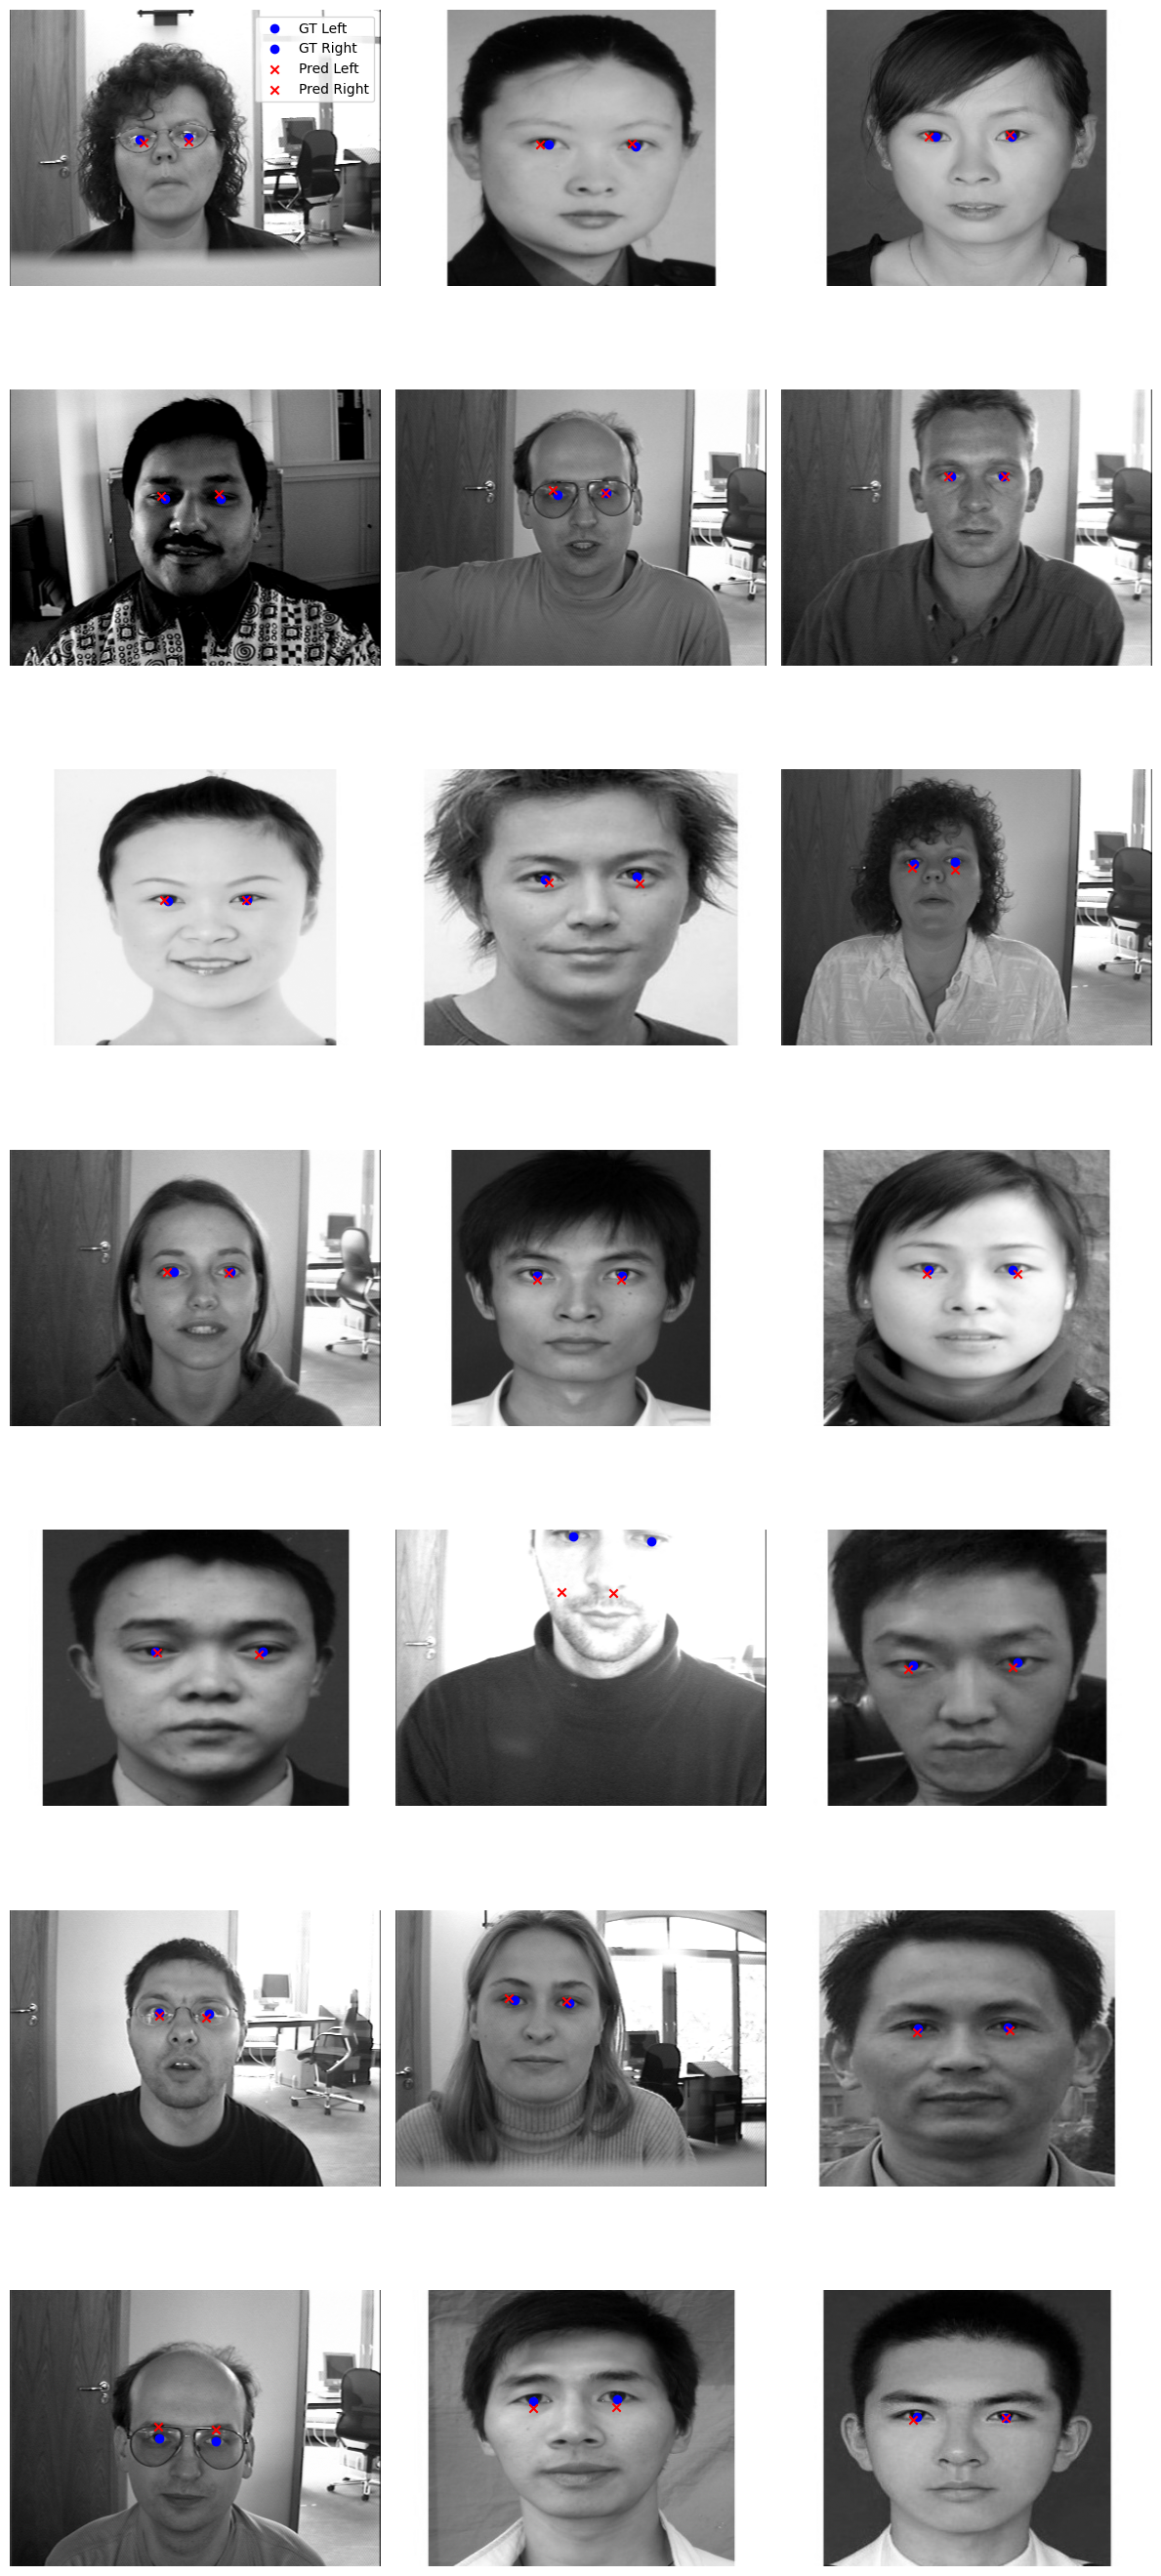

In [ ]:
visualize_predictions(holdout_dataset, predictions, 21, 3)

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/SafeAI_Final/eye_cnn_100epochs.pth")

#### Machine Unlearning: Unlearn Asian Images

In [ ]:
# 학습한 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loaded_model = EyeCNN().to(device)
# loaded_model.load_state_dict(torch.load("/content/drive/MyDrive/SafeAI_Final/eye_cnn_100epochs.pth"))
loaded_model.load_state_dict(torch.load("/content/drive/MyDrive/SafeAI_Final/eye_cnn_250epochs.pth"))
loaded_model.eval()


EyeCNN(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): AdaptiveAvgPool2d(output_size=(4, 6))
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Dropout(p=0.3, inplace=False)
    (15): Linear(in_features=3072, out_feat

In [ ]:
device

device(type='cuda')

In [ ]:
import os
import random

base_path = "/content/drive/MyDrive/BioID-multi-race"
image_files = sorted([f for f in os.listdir(base_path) if f.endswith(".pgm")])

asian_fnames = {f for f in image_files if ('AM' in f or 'AF' in f)}
print(f"폴더 기준 동양인 이미지 수: {len(asian_fnames)} / 전체: {len(image_files)}")

train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

asian_sample_indices = train_df.index[
    train_df["image_path"].apply(lambda p: os.path.basename(p)).isin(asian_fnames)
].tolist()

print(f"train_df 동양인 인덱스 수: {len(asian_sample_indices)} / 전체: {len(train_df)}")

train_dataset = EyeDataset(train_df)
test_dataset  = EyeDataset(test_df)
print(f"train_dataset 길이: {len(train_dataset)}")

valid_indices = [idx for idx in asian_sample_indices if 0 <= idx < len(train_dataset)]
print(f"유효한 동양인 인덱스 수: {len(valid_indices)}")

random.seed(42)
asian_holdout_indices = random.sample(valid_indices, 140)

asian_unlearn_indices = [idx for idx in valid_indices
                         if idx not in asian_holdout_indices]

print(f"hold-out 140장: {len(asian_holdout_indices)}")
print(f"언러닝 대상 1000장: {len(asian_unlearn_indices)}")


폴더 기준 동양인 이미지 수: 1424 / 전체: 2945
train_df 동양인 인덱스 수: 1140 / 전체: 2339
train_dataset 길이: 2339
유효한 동양인 인덱스 수: 1140
hold-out 140장: 140
언러닝 대상 1000장: 1000


In [ ]:
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import time

In [ ]:
def machine_unlearning_gradient_ascent(model, forget_loader, retain_loader, lr=5e-7, epochs=10):
    print(f"[Stage 1] Gradient Ascent Unlearning")
    print(f"Learning rate: {lr}, Epochs: {epochs}")
    print(f"Forget samples: {len(forget_loader.dataset)}, Retain samples: {len(retain_loader.dataset)}")

    for epoch in range(epochs):
        # Forget phase
        model.train()
        epoch_forget_loss = 0
        for batch_idx, (data, targets) in enumerate(forget_loader):
            data, targets = data.to(device), targets.to(device)
            model.zero_grad()

            predictions = model(data)
            forget_loss = F.mse_loss(predictions, targets)
            # forget_loss = torch.clamp(forget_loss, max=20)

            if epoch == 0 and batch_idx == 0:
                print(f"[DEBUG] Forget Loss (Epoch {epoch}, Batch {batch_idx}): {forget_loss.item():.4f}")

            forget_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

            for param in model.parameters():
                if param.grad is not None:
                    param.data += lr * 60 * param.grad  # Gradient Ascent

            epoch_forget_loss += forget_loss.item()

        # Retain phase
        model.eval()
        epoch_retain_loss = 0
        for batch_idx, (data, targets) in enumerate(retain_loader):
            data, targets = data.to(device), targets.to(device)
            model.zero_grad()
            with torch.no_grad():
                _ = model(data)

            model.train()
            predictions = model(data)
            retain_loss = F.mse_loss(predictions, targets)

            retain_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

            for param in model.parameters():
                if param.grad is not None:
                    param.data -= lr * 6 * param.grad  # Gradient Descent

            epoch_retain_loss += retain_loss.item()

        print(f"Epoch {epoch+1}: Forget Loss {epoch_forget_loss / len(forget_loader):.4f}, Retain Loss {epoch_retain_loss / len(retain_loader):.4f}")

    print(f"Stage 1 completed\n")
    return model


In [ ]:
def ft(model, retain_loader, ft_lr=1e-6, ft_epochs=3):
    print(f"[Fine-Tuning] Retain Set")
    optimizer = torch.optim.Adam(model.parameters(), lr=ft_lr)

    for epoch in range(ft_epochs):
        model.train()
        total_loss = 0
        for data, targets in retain_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            predictions = model(data)
            loss = F.mse_loss(predictions, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"FT Epoch {epoch+1}: Loss {total_loss / len(retain_loader):.4f}")
    print("Fine-Tuning Completed\n")
    return model


In [ ]:
def complete_unlearning_pipeline(model, dataset, asian_indices):
    """Complete machine unlearning pipeline with minimal logging"""
    print(f"Machine Unlearning Pipeline Started")
    print(f"Total data: {len(dataset)}, Asian samples: {len(asian_indices)}")
    print(f"Removal ratio: {len(asian_indices)/len(dataset)*100:.1f}%\n")

    # Data splitting
    asian_data = Subset(dataset, asian_indices)
    western_indices = [i for i in range(len(dataset)) if i not in asian_indices]
    western_data = Subset(dataset, western_indices)

    asian_loader = DataLoader(asian_data, batch_size=32, shuffle=True)
    western_loader = DataLoader(western_data, batch_size=32, shuffle=True)

    # Stage 1: Gradient ascent unlearning
    model = machine_unlearning_gradient_ascent(model, asian_loader, western_loader, epochs=5)

    # Stage 2: Fine tuning
    model = ft(model, western_loader)

    print(f"Machine Unlearning Pipeline Completed")
    print(f"Processed {len(asian_indices)} Asian samples")

    return model


In [ ]:
if len(valid_indices) > 0:
    unlearned_model = complete_unlearning_pipeline(
        loaded_model,
        train_dataset,
        asian_unlearn_indices
    )
    print("Success")
else:
    print("Index Out of Range")


Machine Unlearning Pipeline Started
Total data: 2339, Asian samples: 1000
Removal ratio: 42.8%

[Stage 1] Gradient Ascent Unlearning
Learning rate: 5e-07, Epochs: 5
Forget samples: 1000, Retain samples: 1339
[DEBUG] Forget Loss (Epoch 0, Batch 0): 18.9124
Epoch 1: Forget Loss 22.1886, Retain Loss 32.2318
Epoch 2: Forget Loss 24.1590, Retain Loss 33.7440
Epoch 3: Forget Loss 31.0924, Retain Loss 38.5200
Epoch 4: Forget Loss 34.8052, Retain Loss 42.7075
Epoch 5: Forget Loss 43.4901, Retain Loss 50.2406
Stage 1 completed

[Fine-Tuning] Retain Set
FT Epoch 1: Loss 48.1966
FT Epoch 2: Loss 45.8214
FT Epoch 3: Loss 43.2642
Fine-Tuning Completed

Machine Unlearning Pipeline Completed
Processed 1000 Asian samples
Success


In [ ]:
# 결과 저장
torch.save(unlearned_model.state_dict(), '/content/drive/MyDrive/SafeAI_Final/eye_cnn_unlearned.pth')
print("Model Saved: 'eye_cnn_unlearned.pth'")


Model Saved: 'eye_cnn_unlearned.pth'


In [ ]:
# 테스트 데이터에서 동양인/서양인 인덱스 추출
test_asian_indices = []
test_western_indices = []

for idx, row in test_df.iterrows():
    image_name = os.path.basename(row["image_path"])
    if 'AM' in image_name or 'AF' in image_name:
        test_asian_indices.append(idx)
    else:
        test_western_indices.append(idx)

print(f"테스트 동양인 이미지: {len(test_asian_indices)}개")
print(f"테스트 서양인 이미지: {len(test_western_indices)}개")


테스트 동양인 이미지: 273개
테스트 서양인 이미지: 312개


In [ ]:
from torch.utils.data import Subset, DataLoader

# 동양인/서양인 테스트 데이터셋 생성
test_asian_dataset = Subset(test_dataset, test_asian_indices)
test_western_dataset = Subset(test_dataset, test_western_indices)

# 데이터로더 생성
test_asian_loader = DataLoader(test_asian_dataset, batch_size=32, shuffle=False)
test_western_loader = DataLoader(test_western_dataset, batch_size=32, shuffle=False)


In [ ]:
def evaluate_unlearning_effectiveness(original_model, unlearned_model, test_asian_loader, test_western_loader):
    """Evaluate unlearning effectiveness"""

    device = next(original_model.parameters()).device

    def calculate_performance(model, data_loader):
        model.eval()
        total_loss = 0
        with torch.no_grad():
            for data, targets in data_loader:
                data, targets = data.to(device), targets.to(device)
                predictions = model(data)
                loss = F.mse_loss(predictions, targets)
                total_loss += loss.item()
        return total_loss / len(data_loader)

    # Original model performance
    orig_asian_loss = calculate_performance(original_model, test_asian_loader)
    orig_western_loss = calculate_performance(original_model, test_western_loader)

    # Unlearned model performance
    unlearn_asian_loss = calculate_performance(unlearned_model, test_asian_loader)
    unlearn_western_loss = calculate_performance(unlearned_model, test_western_loader)

    print(f"Asian data performance change: {orig_asian_loss:.4f} -> {unlearn_asian_loss:.4f}")
    print(f"Western data performance change: {orig_western_loss:.4f} -> {unlearn_western_loss:.4f}")

    # Calculate unlearning effect ratios
    unlearning_ratio = unlearn_asian_loss / orig_asian_loss
    retention_ratio = unlearn_western_loss / orig_western_loss

    return unlearning_ratio, retention_ratio


In [ ]:
# 원본 모델 로드 (언러닝 전)
original_model = EyeCNN().to(device)
original_model.load_state_dict(torch.load('/content/drive/MyDrive/SafeAI_Final/eye_cnn_250epochs.pth'))
original_model.eval()

unlearning_ratio, retention_ratio = evaluate_unlearning_effectiveness(
    original_model=original_model,
    unlearned_model=unlearned_model,
    test_asian_loader=test_asian_loader,
    test_western_loader=test_western_loader
)

Asian data performance change: 26.3183 -> 47.7931
Western data performance change: 26.6993 -> 38.1176


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

def visualize_multiple_predictions(images, labels, orig_preds, unlearned_preds, count=5, save_dir="prediction_outputs"):
    images = images[:count].cpu()
    labels = labels[:count].cpu().numpy()
    orig_preds = orig_preds[:count].cpu().numpy()
    unlearned_preds = unlearned_preds[:count].cpu().numpy()

    os.makedirs(save_dir, exist_ok=True)

    for i in range(count):
        fig, ax = plt.subplots(figsize=(4, 4))
        img = images[i].squeeze(0).numpy()
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f"Sample {i}")

        lx_gt, ly_gt, rx_gt, ry_gt = labels[i]
        lx_u, ly_u, rx_u, ry_u = unlearned_preds[i]

        ax.scatter([lx_gt, rx_gt], [ly_gt, ry_gt], color='blue', label='GT', s=30)
        ax.scatter([lx_u, rx_u], [ly_u, ry_u], color='red', marker='x', label='Unlearned', s=40)
        ax.plot([lx_gt, lx_u], [ly_gt, ly_u], '--', color='red', linewidth=1)
        ax.plot([rx_gt, rx_u], [ry_gt, ry_u], '--', color='red', linewidth=1)

        left_err = np.linalg.norm([lx_u - lx_gt, ly_u - ly_gt])
        right_err = np.linalg.norm([rx_u - rx_gt, ry_u - ry_gt])
        ax.text(lx_u + 5, ly_u, f"{left_err:.1f}px", color='red', fontsize=8)
        ax.text(rx_u + 5, ry_u, f"{right_err:.1f}px", color='red', fontsize=8)

        ax.legend(loc='lower right', fontsize=8)

        save_path = os.path.join(save_dir, f"sample_{i}.png")
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
        print(f"[✓] 저장됨: {save_path}")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
data_iter = iter(test_asian_loader)
images, labels = next(data_iter)

images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    orig_preds = original_model(images)
    unlearned_preds = unlearned_model(images)

visualize_multiple_predictions(
    images, labels, orig_preds, unlearned_preds,
    count=20,
    save_dir="/content/drive/MyDrive/SafeAI_Final/saved_predictions1"
)

[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/saved_predictions1/sample_0.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/saved_predictions1/sample_1.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/saved_predictions1/sample_2.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/saved_predictions1/sample_3.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/saved_predictions1/sample_4.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/saved_predictions1/sample_5.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/saved_predictions1/sample_6.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/saved_predictions1/sample_7.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/saved_predictions1/sample_8.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/saved_predictions1/sample_9.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/saved_predictions1/sample_10.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/saved_predictions1/sample_11.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/saved_predictions1/sample_12.

In [ ]:
data_iter = iter(test_western_loader)
images, labels = next(data_iter)

images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    orig_preds = original_model(images)
    unlearned_preds = unlearned_model(images)

visualize_multiple_predictions(
    images, labels, orig_preds, unlearned_preds,
    count=20,
    save_dir="/content/drive/MyDrive/SafeAI_Final/saved_predictions2"
)


[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/saved_predictions2/sample_0.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/saved_predictions2/sample_1.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/saved_predictions2/sample_2.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/saved_predictions2/sample_3.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/saved_predictions2/sample_4.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/saved_predictions2/sample_5.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/saved_predictions2/sample_6.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/saved_predictions2/sample_7.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/saved_predictions2/sample_8.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/saved_predictions2/sample_9.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/saved_predictions2/sample_10.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/saved_predictions2/sample_11.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/saved_predictions2/sample_12.

#### Fine-Tuning: Enhance Asian Images

In [ ]:
model = EyeCNN().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/SafeAI_Final/eye_cnn_unlearned.pth", map_location=device))
model.to(device)

EyeCNN(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): AdaptiveAvgPool2d(output_size=(4, 6))
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Dropout(p=0.3, inplace=False)
    (15): Linear(in_features=3072, out_feat

In [ ]:
# forget_indices: 이전에 언러닝 대상이었던 동양인 인덱스 리스트
# asian_sample_indices: 전체 동양인 인덱스
# → retain된 동양인 인덱스 추출
asian_retain_indices = asian_holdout_indices

# 유효한 인덱스만 필터링
valid_asian_retain_indices = [idx for idx in asian_retain_indices if 0 <= idx < len(train_dataset)]

# 해당 서브셋 생성
asian_retain_subset = Subset(train_dataset, valid_asian_retain_indices)

In [ ]:
print(f"[✅ asian_retain_subset 포함 이미지 수]: {len(valid_asian_retain_indices)}\n")

for i, idx in enumerate(valid_asian_retain_indices):
    image_path = train_df.iloc[idx]['image_path']
    print(f"{i+1:>2}. Index: {idx}, File: {os.path.basename(image_path)}")

[✅ asian_retain_subset 포함 이미지 수]: 140

 1. Index: 451, File: AF393.pgm
 2. Index: 114, File: AM355.pgm
 3. Index: 1121, File: AF137.pgm
 4. Index: 1013, File: AF470.pgm
 5. Index: 933, File: AM367.pgm
 6. Index: 564, File: AM311.pgm
 7. Index: 411, File: AF631.pgm
 8. Index: 2277, File: AF565.pgm
 9. Index: 367, File: AF456.pgm
10. Index: 1756, File: AM281.pgm
11. Index: 135, File: AM521.pgm
12. Index: 129, File: AF154.pgm
13. Index: 387, File: AM736.pgm
14. Index: 911, File: AM514.pgm
15. Index: 977, File: AM723.pgm
16. Index: 2104, File: AM653.pgm
17. Index: 118, File: AF403.pgm
18. Index: 829, File: AF331.pgm
19. Index: 1739, File: AF449.pgm
20. Index: 917, File: AF337.pgm
21. Index: 1875, File: AM628.pgm
22. Index: 1135, File: AF225.pgm
23. Index: 33, File: AM415.pgm
24. Index: 662, File: AM481.pgm
25. Index: 1758, File: AF333.pgm
26. Index: 1429, File: AM681.pgm
27. Index: 646, File: AM656.pgm
28. Index: 896, File: AF98.pgm
29. Index: 1403, File: AF71.pgm
30. Index: 384, File: AM2

In [ ]:
class WeightedEyeDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, weight=2.0):
        self.base = base_dataset
        self.weight = weight

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        image, label = self.base[idx]
        return image, label, self.weight


In [ ]:
import copy

def finetune_on_asian_retain(model, dataset, lr=1e-4, epochs=5, batch_size=32):
    print("[Finetuning] Asian retain weight (restore best)")
    model.train()

    weighted_dataset = WeightedEyeDataset(dataset, weight=2.0)
    loader = DataLoader(weighted_dataset, batch_size=batch_size, shuffle=True)

    optimizer  = torch.optim.Adam(model.parameters(), lr=lr)
    best_loss  = float("inf")
    best_state = copy.deepcopy(model.state_dict())

    for epoch in range(epochs):
        epoch_loss = 0.0

        for images, targets, weights in loader:
            images, targets = images.to(device), targets.to(device)
            weights = weights.to(device)

            optimizer.zero_grad()
            preds = model(images)

            loss = F.mse_loss(preds, targets, reduction="none")
            loss = (loss.mean(dim=1) * weights).mean()

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(loader)
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")

        if avg_loss < best_loss:
            best_loss  = avg_loss
            best_state = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_state)
    print(f"Fin (best loss = {best_loss:.4f})")
    return model

In [ ]:
model = finetune_on_asian_retain(model, asian_retain_subset, lr=1e-4, epochs=50)


[Finetuning] Asian retain weight (restore best)
Epoch 1: Loss = 62.6892
Epoch 2: Loss = 41.9478
Epoch 3: Loss = 40.0817
Epoch 4: Loss = 36.6003
Epoch 5: Loss = 35.8545
Epoch 6: Loss = 37.6590
Epoch 7: Loss = 29.7140
Epoch 8: Loss = 32.5359
Epoch 9: Loss = 34.4990
Epoch 10: Loss = 34.4706
Epoch 11: Loss = 31.3670
Epoch 12: Loss = 35.0376
Epoch 13: Loss = 33.1717
Epoch 14: Loss = 30.9294
Epoch 15: Loss = 30.5744
Epoch 16: Loss = 33.1343
Epoch 17: Loss = 33.1300
Epoch 18: Loss = 29.1083
Epoch 19: Loss = 30.9646
Epoch 20: Loss = 30.9457
Epoch 21: Loss = 30.1033
Epoch 22: Loss = 34.7971
Epoch 23: Loss = 28.3666
Epoch 24: Loss = 29.5546
Epoch 25: Loss = 28.8012
Epoch 26: Loss = 25.1347
Epoch 27: Loss = 33.5716
Epoch 28: Loss = 35.1216
Epoch 29: Loss = 28.3270
Epoch 30: Loss = 29.5983
Epoch 31: Loss = 32.1362
Epoch 32: Loss = 26.8042
Epoch 33: Loss = 29.1420
Epoch 34: Loss = 35.5625
Epoch 35: Loss = 30.6680
Epoch 36: Loss = 26.6399
Epoch 37: Loss = 28.1614
Epoch 38: Loss = 28.9858
Epoch 39: L

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/SafeAI_Final/eye_cnn_refined.pth")
print("Saved: eye_cnn_refined.pth")

Saved: eye_cnn_refined.pth


#### Visualize

In [ ]:
def visualize_triplet_predictions(images, labels, preds_orig, preds_unl, preds_ref, count=5, save_dir="triplet_outputs"):
    os.makedirs(save_dir, exist_ok=True)

    images = images[:count].cpu()
    labels = labels[:count].cpu().numpy()
    preds_orig = preds_orig[:count].cpu().numpy()
    preds_unl = preds_unl[:count].cpu().numpy()
    preds_ref = preds_ref[:count].cpu().numpy()

    for i in range(count):
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        img = images[i].squeeze(0).numpy()

        # GT 좌표
        lx_gt, ly_gt, rx_gt, ry_gt = labels[i]

        for ax, title, pred in zip(
            axes,
            ["Original", "Unlearned", "Refined"],
            [preds_orig[i], preds_unl[i], preds_ref[i]]
        ):
            lx_p, ly_p, rx_p, ry_p = pred
            ax.imshow(img, cmap="gray")
            ax.set_title(title)
            ax.axis("off")
            ax.scatter([lx_gt, rx_gt], [ly_gt, ry_gt], c="blue", s=30, label="GT")
            ax.scatter([lx_p, rx_p], [ly_p, ry_p], c="red", marker="x", s=40, label="Pred")
            ax.plot([lx_gt, lx_p], [ly_gt, ly_p], "--", c="red", lw=1)
            ax.plot([rx_gt, rx_p], [ry_gt, ry_p], "--", c="red", lw=1)

            err_l = np.linalg.norm([lx_p - lx_gt, ly_p - ly_gt])
            err_r = np.linalg.norm([rx_p - rx_gt, ry_p - ry_gt])
            ax.text(lx_p + 5, ly_p, f"{err_l:.1f}px", color="red", fontsize=8)
            ax.text(rx_p + 5, ry_p, f"{err_r:.1f}px", color="red", fontsize=8)

        handles, labels_ = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels_, loc="upper center", ncol=3)
        plt.tight_layout()

        save_path = os.path.join(save_dir, f"triplet_{i}.png")
        plt.savefig(save_path, bbox_inches="tight")
        plt.close()
        print(f"[✓] 저장됨: {save_path}")

In [ ]:
refined_model = EyeCNN().to(device)
refined_model.load_state_dict(torch.load("eye_cnn_refined.pth", map_location=device))
refined_model.to(device)

data_iter = iter(test_asian_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    preds_orig = original_model(images)
    preds_unl  = unlearned_model(images)
    preds_ref  = refined_model(images)

visualize_triplet_predictions(
    images, labels,
    preds_orig, preds_unl, preds_ref,
    count=20,
    save_dir="/content/drive/MyDrive/SafeAI_Final/triplet_predictions"
)


[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/triplet_predictions/triplet_0.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/triplet_predictions/triplet_1.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/triplet_predictions/triplet_2.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/triplet_predictions/triplet_3.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/triplet_predictions/triplet_4.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/triplet_predictions/triplet_5.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/triplet_predictions/triplet_6.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/triplet_predictions/triplet_7.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/triplet_predictions/triplet_8.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/triplet_predictions/triplet_9.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/triplet_predictions/triplet_10.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/triplet_predictions/triplet_11.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/tripl

#### Black-Box

In [ ]:
def blackbox(images, labels, preds_orig, preds_unl, preds_ref, count=5, save_dir="triplet_outputs"):
    os.makedirs(save_dir, exist_ok=True)

    images = images[:count].cpu()
    labels = labels[:count].cpu().numpy()
    preds_orig = preds_orig[:count].cpu().numpy()
    preds_unl = preds_unl[:count].cpu().numpy()
    preds_ref = preds_ref[:count].cpu().numpy()

    for i in range(count):
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        img = images[i].squeeze(0).numpy()

        # GT 좌표
        lx_gt, ly_gt, rx_gt, ry_gt = labels[i]

        for ax, title, pred in zip(
            axes,
            ["Original", "Unlearned", "Refined"],
            [preds_orig[i], preds_unl[i], preds_ref[i]]
        ):
            lx_p, ly_p, rx_p, ry_p = pred
            ax.imshow(img, cmap="gray")
            ax.set_title(title)
            ax.axis("off")

            ax.scatter([lx_gt, rx_gt], [ly_gt, ry_gt], c="blue", s=30, label="GT")
            ax.scatter([lx_p, rx_p], [ly_p, ry_p], c="red", marker="x", s=40, label="Pred")

            ax.plot([lx_p, rx_p], [ly_p, ry_p], "-", color="black", linewidth=14)

            err_l = np.linalg.norm([lx_p - lx_gt, ly_p - ly_gt])
            err_r = np.linalg.norm([rx_p - rx_gt, ry_p - ry_gt])
            ax.text(lx_p + 5, ly_p, f"{err_l:.1f}px", color="red", fontsize=8)
            ax.text(rx_p + 5, ry_p, f"{err_r:.1f}px", color="red", fontsize=8)

        handles, labels_ = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels_, loc="upper center", ncol=3)
        plt.tight_layout()

        save_path = os.path.join(save_dir, f"triplet_{i}.png")
        plt.savefig(save_path, bbox_inches="tight")
        plt.close()
        print(f"[✓] 저장됨: {save_path}")


In [ ]:
refined_model = EyeCNN().to(device)
refined_model.load_state_dict(torch.load("eye_cnn_refined.pth", map_location=device))
refined_model.to(device)

data_iter = iter(test_asian_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    preds_orig = original_model(images)
    preds_unl  = unlearned_model(images)
    preds_ref  = refined_model(images)

blackbox(
    images, labels,
    preds_orig, preds_unl, preds_ref,
    count=20,
    save_dir="/content/drive/MyDrive/SafeAI_Final/blackbox"
)


[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/blackbox/triplet_0.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/blackbox/triplet_1.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/blackbox/triplet_2.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/blackbox/triplet_3.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/blackbox/triplet_4.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/blackbox/triplet_5.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/blackbox/triplet_6.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/blackbox/triplet_7.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/blackbox/triplet_8.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/blackbox/triplet_9.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/blackbox/triplet_10.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/blackbox/triplet_11.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/blackbox/triplet_12.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final/blackbox/triplet_13.png
[✓] 저장됨: /content/drive/MyDrive/SafeAI_Final